In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


character(0)

# Project Proposal

I will be using a dataset that contains information for each flight departing from one of New York City’s three airports during the year 2013. The data were provided by the Federal Aviation Administration (FAA) and organized into an R package by Hadley Wickham, leader of the Tidyverse (collection of R packages/libraries for data science) team. I am using this dataset because of my interest in aviation. I also like this dataset because it has a relatively small number of features but a large (almost 337,000) number of observations. My goal in this project is to find out which features have the greatest effect on arrival delay. 

 
This dataset has a relatively small number of features, so I plan to start by finding summary statistics and creating simple visualizations for each of the relevant features. Then, I plan to examine correlations to potentially create new features and determine which features to use as predictors. Feature engineering may also be necessary to convert some of the features to more appropriate data types. 
	Because the response (arrival delay) is numerical, my first model will be a simple linear regression model. For more advanced models, I would like to try random forests and XGBoost because both models have performed very well in high-profile Kaggle competitions. I do not intend to use an artificial neural network because I don’t believe it will be necessary to create an accurate model. 

 
I will be using R throughout the project. I am choosing R over Python because I am much more familiar with it, I think the syntax is more intuitive, and its capabilities for most data science tasks are comparable to those of Python. The most important library I will be using is “dplyr”, which will allow me to do any required preprocessing/feature engineering (similarly to Pandas for Python). I will be using “ggplot2” for all visualizations. I will use “caret” to fit the machine learning models, and I plan to use “corrr” for correlations and “yardstick” for evaluation. 

# Data analysis

First thing to do is load the required packages: 

In [2]:
library(dplyr) # data management
library(ggplot2) # visualizations
library(nycflights13) # dataset

Combine flight data with airplane data, then get summary statistics

In [3]:
# add airplane data
flights_full = flights %>% 
  left_join(planes %>% 
              select(tailnum, type, manufacturer, model, engine), by = "tailnum")

# summary
summary(flights_full)

      year          month             day           dep_time    sched_dep_time
 Min.   :2013   Min.   : 1.000   Min.   : 1.00   Min.   :   1   Min.   : 106  
 1st Qu.:2013   1st Qu.: 4.000   1st Qu.: 8.00   1st Qu.: 907   1st Qu.: 906  
 Median :2013   Median : 7.000   Median :16.00   Median :1401   Median :1359  
 Mean   :2013   Mean   : 6.549   Mean   :15.71   Mean   :1349   Mean   :1344  
 3rd Qu.:2013   3rd Qu.:10.000   3rd Qu.:23.00   3rd Qu.:1744   3rd Qu.:1729  
 Max.   :2013   Max.   :12.000   Max.   :31.00   Max.   :2400   Max.   :2359  
                                                 NA's   :8255                 
   dep_delay          arr_time    sched_arr_time   arr_delay       
 Min.   : -43.00   Min.   :   1   Min.   :   1   Min.   : -86.000  
 1st Qu.:  -5.00   1st Qu.:1104   1st Qu.:1124   1st Qu.: -17.000  
 Median :  -2.00   Median :1535   Median :1556   Median :  -5.000  
 Mean   :  12.64   Mean   :1502   Mean   :1536   Mean   :   6.895  
 3rd Qu.:  11.00   3rd Qu.:1

We want to predict arrival delay, so remove the observations that don't have it

In [4]:
# remove all flights with no arrival delay
flights_full = flights_full %>% 
  filter(!is.na(flights_full$arr_delay))

Get rid of missing values. Since they are all categorical, we can just replace with "Unknown"

In [5]:
# count NAs per column
data.frame(sapply(flights_full, function(x) sum(is.na(x)))) %>% 
  rename(missing_values = 1) %>% 
  filter(missing_values > 0) %>% 
  arrange(desc(missing_values)) %>% 
  print()

# replace NAs in dataframe
flights_full[is.na(flights_full)] = "Unknown"

             missing_values
type                  48329
manufacturer          48329
model                 48329
engine                48329


These next few steps aren't needed right now, but will make model training more accurate later on

In [6]:
# convert hrs/mins into minutes
dep_mins = (flights_full$dep_time %% 100) + (flights_full$dep_time - (flights_full$dep_time %% 100)) * 0.6
sched_dep_mins = (flights_full$sched_dep_time %% 100) + (flights_full$sched_dep_time - (flights_full$sched_dep_time %% 100)) * 0.6
arr_mins = (flights_full$arr_time %% 100) + (flights_full$arr_time - (flights_full$arr_time %% 100)) * 0.6
sched_arr_mins = (flights_full$sched_arr_time %% 100) + (flights_full$sched_arr_time - (flights_full$sched_arr_time %% 100)) * 0.6

# convert month/day into day of year
days_per_month = c(0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334)
day_of_year = days_per_month[flights_full$month] + flights_full$day

# add new columns to dataframe
flights_full = flights_full %>% 
  mutate(dep_mins, 
         sched_dep_mins, 
         arr_mins, 
         sched_arr_mins, 
         day_of_year)

More detailed summary statistics, grouped by month, carrier (airline) and origin

In [7]:
# summary stats
# mean delay by month
by_month = flights_full %>% 
  group_by(month) %>% 
  summarize(total = sum(n()), 
            delay_mean = mean(arr_delay))
by_month

# mean delay by carrier
by_carrier = flights_full %>% 
  group_by(carrier) %>% 
  summarize(total = sum(n()), 
            delay_mean = mean(arr_delay)) %>% 
  arrange(desc(total))
by_carrier

# mean delay by origin
by_origin = flights_full %>% 
  group_by(origin) %>% 
  summarize(total = sum(n()), 
            delay_mean = mean(arr_delay))
by_origin

month,total,delay_mean
<int>,<int>,<dbl>
1,26398,6.1299720
2,23611,5.6130194
3,27902,5.8075765
4,27564,11.1760630
5,28128,3.5215088
6,27075,16.4813296
7,28293,16.7113067
8,28756,6.0406524
9,27010,-4.0183636


carrier,total,delay_mean
<chr>,<int>,<dbl>
UA,57782,3.5580111
B6,54049,9.4579733
EV,51108,15.7964311
DL,47658,1.6443409
AA,31947,0.3642909
MQ,25037,10.7747334
US,19831,2.1295951
9E,17294,7.3796692
WN,12044,9.6491199


origin,total,delay_mean
<chr>,<int>,<dbl>
EWR,117127,9.107055
JFK,109079,5.551481
LGA,101140,5.783488


First data visualization: what is the average arrival delay for each combination of month and origin? 

`summarise()` has grouped output by 'month', 'carrier'. You can override using
the `.groups` argument.


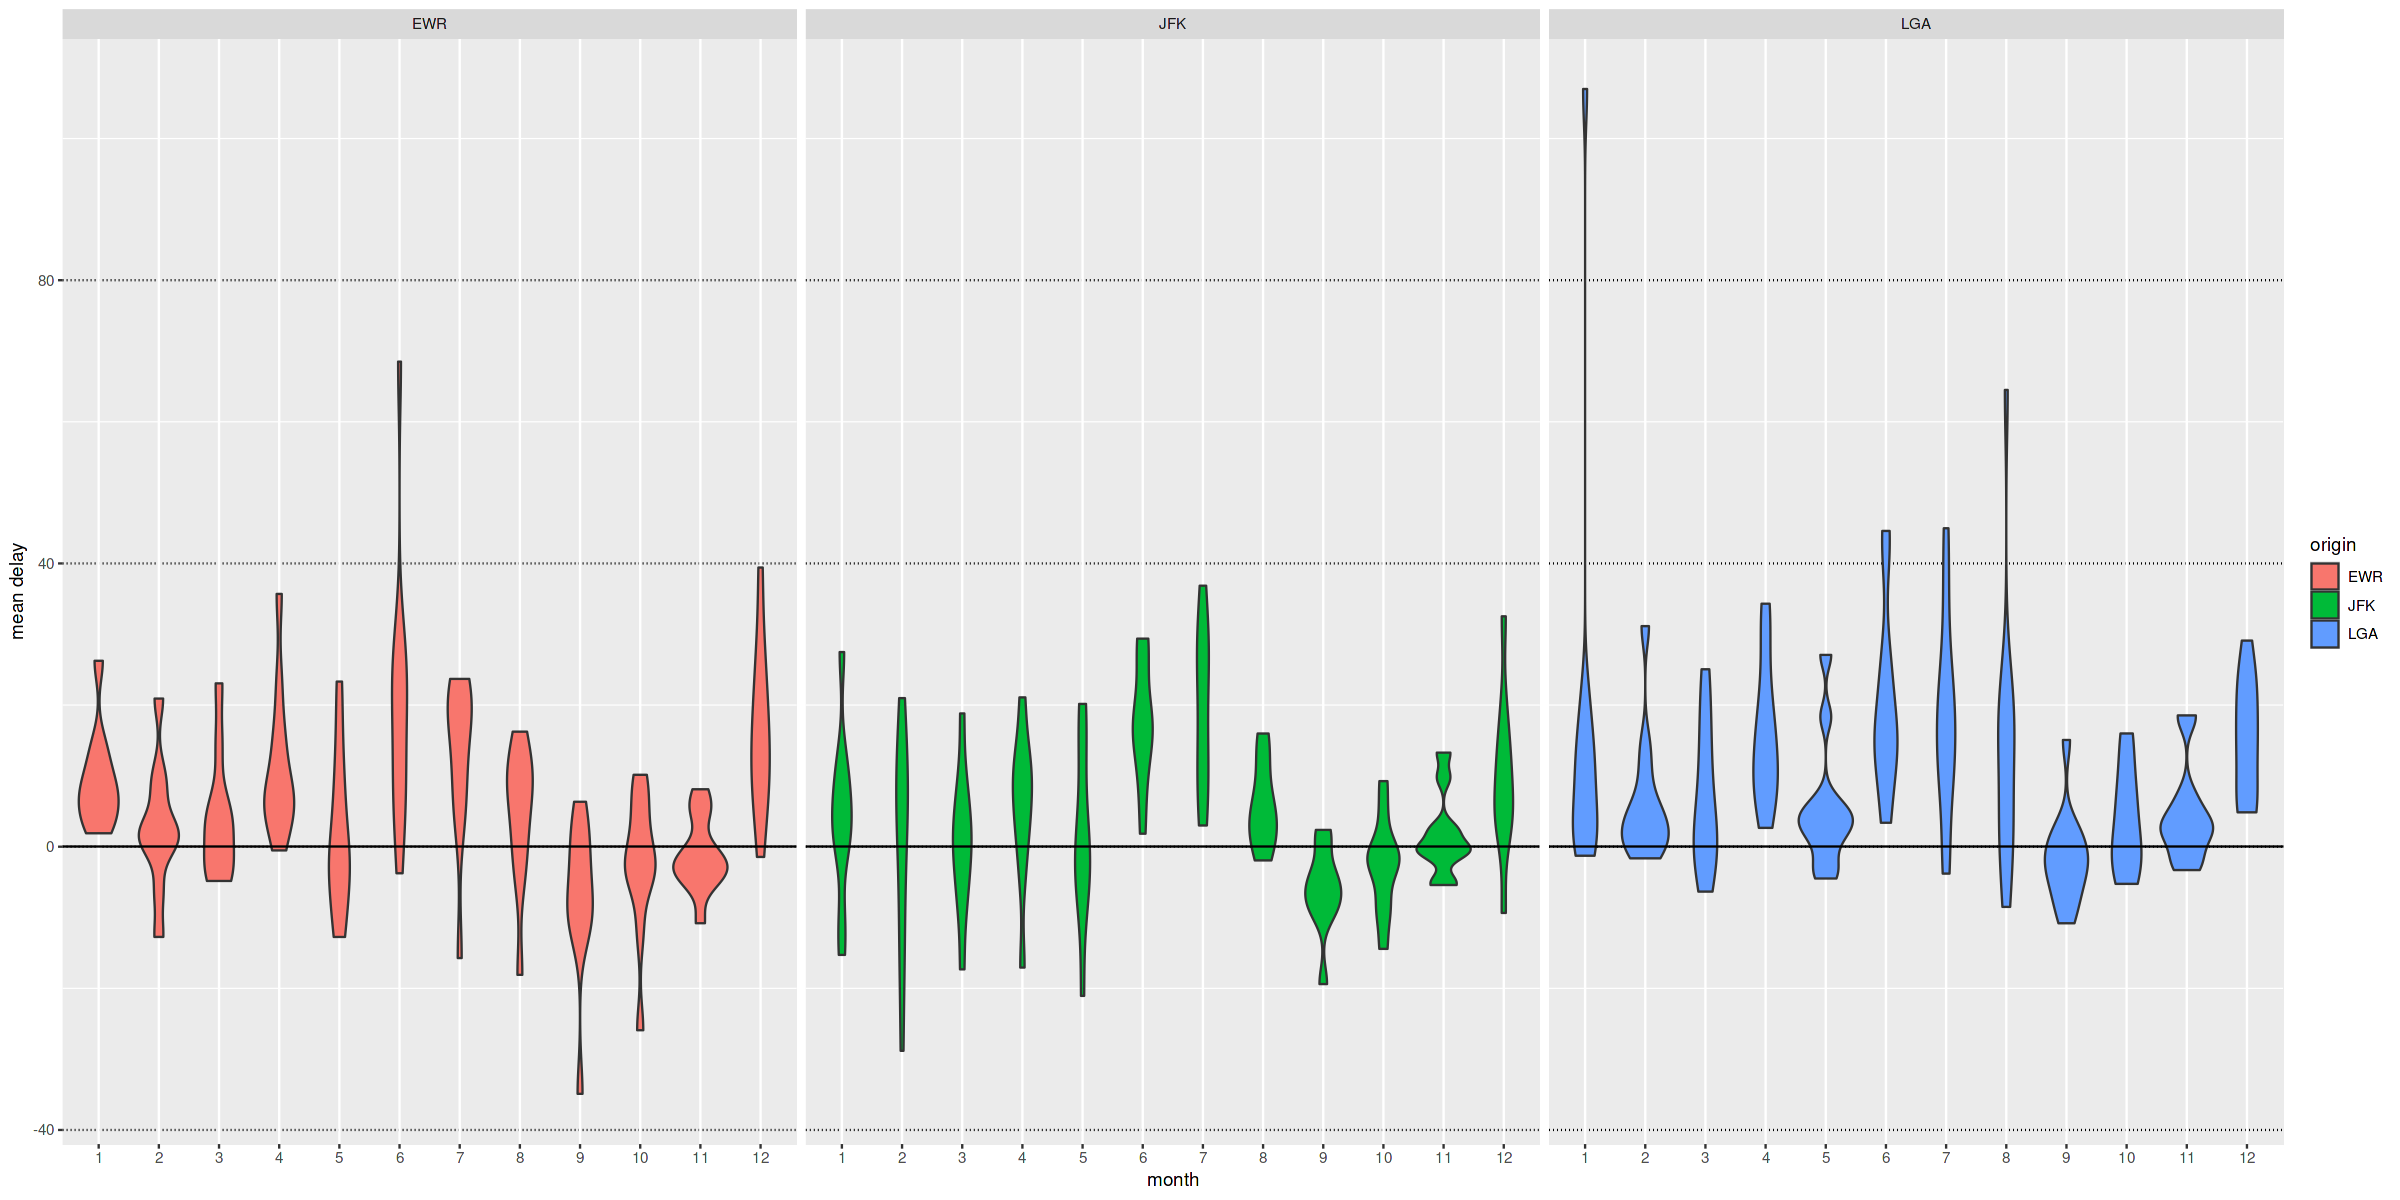

In [8]:
# smaller dataframe with data for the visualization
df = flights_full %>% 
  group_by(month, carrier, origin) %>% 
  summarize(total = sum(n()), 
            delay_mean = mean(arr_delay)) %>% 
  arrange(desc(total))

# make the plot big enough to read
options(repr.plot.width = 20, repr.plot.height = 10)

# the plot
ggplot(df, mapping = aes(x = as.factor(month), y = delay_mean, fill = as.factor(origin))) + 
  geom_violin() + 
  facet_wrap(vars(origin), nrow = 1, ncol = 3) + 
  labs(x = "month", y = "mean delay", fill = "origin") + 
  geom_hline(yintercept = 0) + 
  scale_y_continuous(breaks = seq(-40, 100, by = 40)) + 
  theme(panel.grid.major.y = element_line(color = "black", 
                                          linewidth = 0.5, 
                                          linetype = 3))